In [20]:
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib import rc
rc("font", family = "Malgun Gothic")
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, r2_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import mean_squared_error, mean_squared_log_error 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_rmsle(model):
    pred = model.predict(X_test)
    pred = np.expm1(pred)  # 로그 역변환 (inverse log transformation)
    y_test_exp = np.expm1(y_test)  # 로그 역변환 (inverse log transformation)
    rmsle = np.sqrt(mean_squared_log_error(y_test_exp, pred))
    print(f"{model.__class__.__name__} RMSLE: {np.round(rmsle, 3)}")
    return rmsle

def get_rmsles(models):
    rmsles = []
    for model in models:
        rmsle = get_rmsle(model)
        rmsles.append(rmsle)
    return rmsles

In [3]:
def compare_arrays(arr1, arr2):
    count = 0
    for i in range(len(arr1)):
        if arr1[i] == arr2[i]:
            count += 1
    return count

def convert_values(arr):
    result = []
    for value in arr:
        if value < 85:
            result.append(3)
        elif value < 115:
            result.append(2)
        else:
            result.append(1)
    return result

def get_scores(arr1, arr2):
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for i in range(len(arr1)):
        if arr2[i] == 3 and arr1[i] == 3:
            TP += 1
        elif arr2[i] == 3 and arr1[i] != 3:
            FN += 1
        elif arr2[i] != 3 and arr1[i] != 3:
            TN += 1
        else:
            FP += 1
    print(f"[{TP}   {FP}]\n[{FN}   {TN}]")
    print(f"정밀도 : {round(TP/ (FP+TP)*100,2)}%")
    print(f"재현율 : {round(TP/ (FN+TP)*100,2)}%")
    print(f"정확도 : {round((TP+TN)/len(arr1)*100,2)}%")
    
def convert(x):
    cat = ''
    if x < 90 : cat = 3
    elif x < 110 : cat = 2
    else : cat = 1
    
    return cat

def convert2(x):
    cat = ''
    if x == 3 : cat = 1
    else : cat = 0
    
    return cat    

def get_rank(x):
    cat = ''
    if x < 1886 : cat = 1
    elif x < 3773 : cat = 2
    elif x < 5659 : cat = 3
    elif x < 7546 : cat = 4
    elif x < 9433 : cat = 5
    elif x < 11319 : cat = 6
    elif x < 13206 : cat = 7
    elif x < 15092 : cat = 8
    elif x < 16979 : cat = 9   
    else: cat = 10
        
    
    return cat

In [4]:
traindata = pd.read_pickle("dataSet/classtrain.pkl")
testdata = pd.read_pickle("dataSet/classtest.pkl")
traindata = traindata[traindata["선호제휴점포"].isin(traindata["선호제휴점포"].value_counts().index[traindata["선호제휴점포"].value_counts() > 30])]
testdata = testdata[testdata["선호제휴점포"].isin(testdata["선호제휴점포"].value_counts().index[testdata["선호제휴점포"].value_counts() > 30])]

In [5]:
traindata["Label"] = traindata["Label"].apply(lambda x : convert(x))
testdata["Label"] = testdata["Label"].apply(lambda x : convert(x))
traindata["Label"] = traindata["Label"].apply(lambda x : convert2(x))
testdata["Label"] = testdata["Label"].apply(lambda x : convert2(x))

In [6]:
traindata['14_1F'] = traindata['14_1F'].rank(method='min')
traindata['14_2F'] = traindata['14_2F'].rank(method='min')
traindata['14_3F'] = traindata['14_3F'].rank(method='min')
traindata['14_4F'] = traindata['14_4F'].rank(method='min')
traindata['15_1F'] = traindata['15_1F'].rank(method='min')
traindata['15_2F'] = traindata['15_2F'].rank(method='min')

In [7]:
testdata['14_2F'] = testdata['14_2F'].rank(method='min')
testdata['14_3F'] = testdata['14_3F'].rank(method='min')
testdata['14_4F'] = testdata['14_4F'].rank(method='min')
testdata['15_1F'] = testdata['15_1F'].rank(method='min')
testdata['15_2F'] = testdata['15_2F'].rank(method='min')
testdata['15_3F'] = testdata['15_3F'].rank(method='min')

In [8]:
traindata['14_1F'] = traindata['14_1F'].apply(lambda x : get_rank(x))
traindata['14_2F'] = traindata['14_2F'].apply(lambda x : get_rank(x))
traindata['14_3F'] = traindata['14_3F'].apply(lambda x : get_rank(x))
traindata['14_4F'] = traindata['14_4F'].apply(lambda x : get_rank(x))
traindata['15_1F'] = traindata['15_1F'].apply(lambda x : get_rank(x))
traindata['15_2F'] = traindata['15_2F'].apply(lambda x : get_rank(x))

In [9]:
testdata['14_2F'] = testdata['14_2F'].apply(lambda x : get_rank(x))
testdata['14_3F'] = testdata['14_3F'].apply(lambda x : get_rank(x))
testdata['14_4F'] = testdata['14_4F'].apply(lambda x : get_rank(x))
testdata['15_1F'] = testdata['15_1F'].apply(lambda x : get_rank(x))
testdata['15_2F'] = testdata['15_2F'].apply(lambda x : get_rank(x))
testdata['15_3F'] = testdata['15_3F'].apply(lambda x : get_rank(x))

In [10]:
traindata.drop(["성별", "연령대", "거주지역", "선호제휴점포", "F rank"], axis = 1, inplace = True)
testdata.drop(["성별", "연령대", "거주지역", "선호제휴점포", "F rank"], axis = 1, inplace = True)

In [11]:
pd.set_option("display.max_columns", None)
traindata

,14_1F,14_2F,14_3F,14_4F,15_1F,15_2F,가공변화율,가공순증감률,신선변화율,신선순증감률,일상변화율,일상순증감률,의약변화율,의약순증감률,교육변화율,교육순증감률,디지털변화율,디지털순증감률,가구변화율,가구순증감률,의류변화율,의류순증감률,전문스포츠변화율,전문스포츠순증감률,패션변화율,패션순증감률,명품변화율,명품순증감률,기타변화율,기타순증감률,종합변화율,종합순증감률,R rank,M rank,Label
0,3,3,6,4,3,4,10,2,1,-1,9,-1,1,-1,3,-1,0,0,7,1,7,1,3,-1,11,-3,3,-1,15,1,0,0,9,8,1
1,4,1,4,4,4,5,13,1,7,1,16,0,3,-3,0,0,5,1,4,0,7,3,4,0,0,0,1,-1,15,1,4,0,5,10,0
2,7,6,7,7,6,7,7,1,9,-3,14,2,1,-1,2,0,0,0,2,0,5,-3,5,1,8,-2,1,-1,9,-1,7,1,1,5,0
4,3,3,2,1,4,3,8,2,16,3,5,1,1,-1,0,0,8,0,8,0,6,0,7,-1,10,2,2,0,17,-5,8,0,1,9,0
5,3,4,6,5,5,4,5,-1,7,5,13,3,2,0,2,0,3,1,9,1,0,0,12,0,7,-5,8,0,5,3,4,0,5,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19373,4,3,3,4,4,3,8,-2,11,3,6,0,3,-1,0,0,0,0,2,0,4,0,3,-1,8,2,1,-1,7,-3,7,-1,1,2,1
19374,8,8,8,8,8,8,12,2,2,0,3,1,1,-1,0,0,0,0,2,0,6,0,7,-1,2,2,3,-1,6,2,7,1,1,5,0
19377,8,8,8,8,8,8,2,0,5,2,5,1,1,-1,0,0,0,0,2,0,3,-3,3,-1,6,0,1,-1,2,0,2,0,8,5,1
19380,4,8,7,7,6,7,13,1,5,5,12,0,4,0,0,0,2,-2,7,1,15,3,4,-2,19,1,1,-1,11,-1,7,3,1,6,0


In [12]:
train_ohe = pd.get_dummies(traindata)
test_ohe = pd.get_dummies(testdata)

In [13]:
y_train = train_ohe["Label"]
y_test = test_ohe["Label"]

X_train = train_ohe.drop(["Label"], axis = 1)
X_test = test_ohe.drop(["Label"], axis = 1)

In [14]:
# dt = DecisionTreeClassifier()
# dt.fit(X_train, y_train)

# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)

# dt_pred = dt.predict(X_test)
# rf_pred = rf.predict(X_test)

# print(round(accuracy_score(y_test, dt_pred),2))
# print(round(accuracy_score(y_test, rf_pred),2))

In [15]:
# feature_importance_dt = dt.feature_importances_[:20]
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(feature_importance_dt)), feature_importance_dt)
# plt.xticks(range(len(feature_importance_dt)), X_train.columns[:20], rotation=45)
# plt.xlabel('Features')
# plt.ylabel('Importance')
# plt.title('Decision Tree Feature Importance')
# plt.show()

In [16]:
# feature_importance_rf = rf.feature_importances_[:20]
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(feature_importance_rf)), feature_importance_rf)
# plt.xticks(range(len(feature_importance_rf)), X_train.columns[:20], rotation=45)
# plt.xlabel('Features')
# plt.ylabel('Importance')
# plt.title('Random Forest Feature Importance')
# plt.show()

In [17]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

print(f"accuracy : {accuracy_score(y_test, lr_preds):.4f}")
print(f"roc_auc : {roc_auc_score(y_test, lr_preds):.4f}")

accuracy : 0.6254
roc_auc : 0.5814


In [18]:
lgbm = LGBMClassifier()
lgbm.fit(X_train,y_train)
lgbm_preds = lgbm.predict(X_test)

print(f"accuracy : {accuracy_score(y_test, lgbm_preds):.4f}")
print(f"roc_auc : {roc_auc_score(y_test, lgbm_preds):.4f}")

accuracy : 0.6292
roc_auc : 0.5930


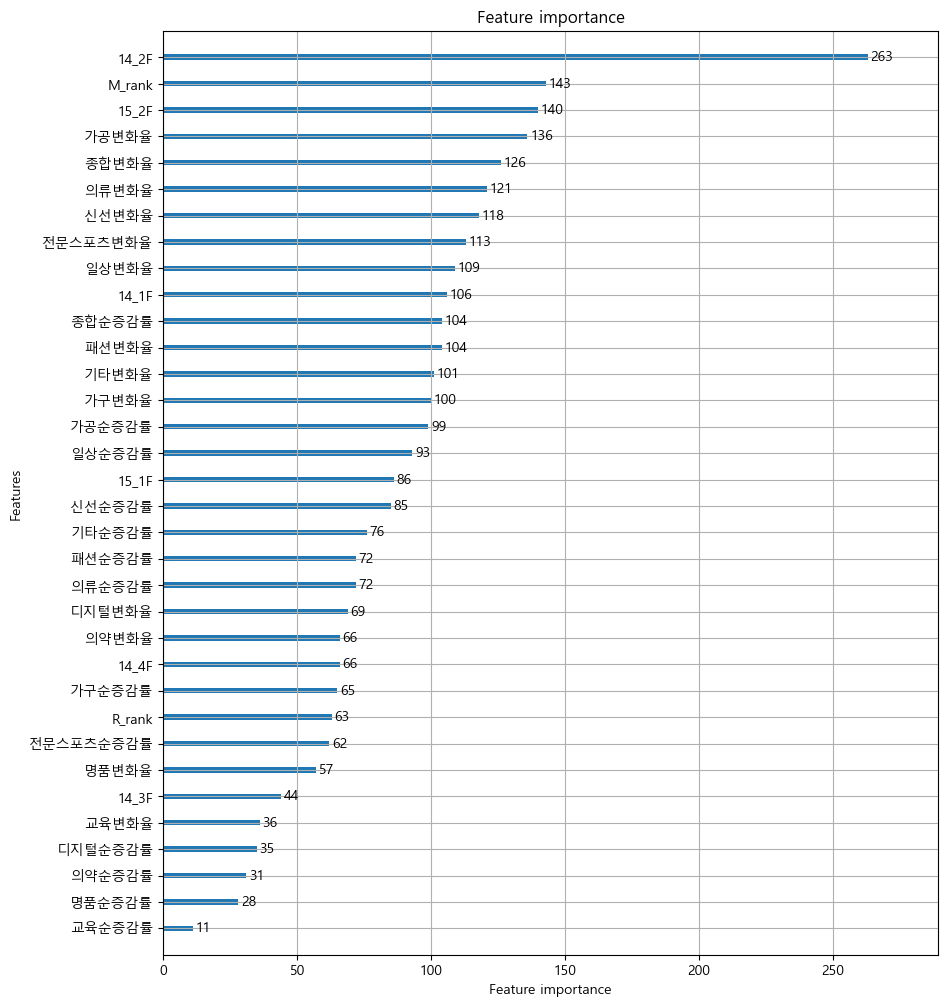

In [19]:
fig, ax = plt.subplots(figsize = (10, 12))
plot_importance(lgbm, ax = ax)
plt.savefig("lightgbm_feature_importance.tif", format = "tif", dpi = 300, bbox_inches = "tight")

In [24]:
# params = {"learning_rate" : [0.01, 0.05, 0.1, 1, 5],
#          "n_estimators" : [50, 100, 500, 1000],
#          "max_depth" : [3, 5, 7, 10]}

# grid = GridSearchCV(lgbm, param_grid=params, cv=3, refit=True)
# grid.fit(X_train, y_train)
# print('GridSearchCV 최적 파라미터:', grid.best_params_)
# print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid.best_score_))

GridSearchCV 최적 파라미터: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}
GridSearchCV 최고 정확도: 0.6833


In [26]:
lgbm = LGBMClassifier(learning_rate= 0.05, max_depth= 3, n_estimators= 500)
lgbm.fit(X_train,y_train)
lgbm_preds = lgbm.predict(X_test)

print(f"accuracy : {accuracy_score(y_test, lgbm_preds):.4f}")
print(f"roc_auc : {roc_auc_score(y_test, lgbm_preds):.4f}")

accuracy : 0.6274
roc_auc : 0.5891


In [ ]:
lgbm_p